## Time Series Analysis of Litecoin Cryptocurrency in Python

Shpaner, Leonid - March 11. 2022

The following time series analysis is an update to the pre-existing analysis conducted in R, but this time done in Python. The data is sourced from Yahoo Finance.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt

In [2]:
ltc = yf.download('LTC-USD', start ='2011-01-01', 
                     end='2022-03-10', progress=False)

In [3]:
ltc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840
2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260
2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450
2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660
2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220


### Simple Returns
Simple returns are aggregated over assets, which is a "weighted sum of the returns of the individual assests in the portfolio" (Lewinson, 2020).

$$R_t = \frac{(P_t-P_{t-1})}{P_{t-1}} = \frac{P_t}{P_{t-1}}-1$$

### Log Returns

Log returns are aggregated over time.

$$r_t = log\left(\frac{P_t}{P_{t-1}}\right) = log(P_t) - log(P_t-1)$$

In [4]:
ltc.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
ltc['simple_rtn'] = ltc.adj_close.pct_change()
ltc['log_rtn'] = np.log(ltc.adj_close/ltc.adj_close.shift(1))

In [5]:
ltc

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2014-09-17,5.085890,5.170770,4.965950,5.058550,5.058550,3071840,NaN,NaN
2014-09-18,5.065430,5.065430,4.579960,4.685230,4.685230,4569260,-0.073800,-0.076665
2014-09-19,4.687290,4.755820,4.254350,4.327770,4.327770,3917450,-0.076295,-0.079363
2014-09-20,4.329200,4.616080,4.202190,4.286440,4.286440,5490660,-0.009550,-0.009596
2014-09-21,4.263070,4.300130,4.154990,4.245920,4.245920,2931220,-0.009453,-0.009498
...,...,...,...,...,...,...,...,...
2022-03-06,104.980621,105.609085,101.545616,101.593918,101.593918,563304861,-0.032229,-0.032759
2022-03-07,101.595879,103.662041,97.236954,98.869263,98.869263,756482342,-0.026819,-0.027185
2022-03-08,98.861572,102.160332,98.499702,100.617645,100.617645,699527175,0.017684,0.017529


In [6]:
# ltc.reset_index(inplace=True)

In [7]:
ltc.head()
# ltc['Date'] = pd.to_datetime(ltc['Date'])

,Open,High,Low,Close,adj_close,Volume,simple_rtn,log_rtn
Date,,,,,,,,
2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840,NaN,NaN
2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260,-0.073800,-0.076665
2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450,-0.076295,-0.079363
2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660,-0.009550,-0.009596
2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220,-0.009453,-0.009498


In [8]:
ltc.dtypes

Open          float64
High          float64
Low           float64
Close         float64
adj_close     float64
Volume          int64
simple_rtn    float64
log_rtn       float64
dtype: object

Below, litecoin's historical prices (2015 - Present), simple returns, and log returns, respectively, are shown.

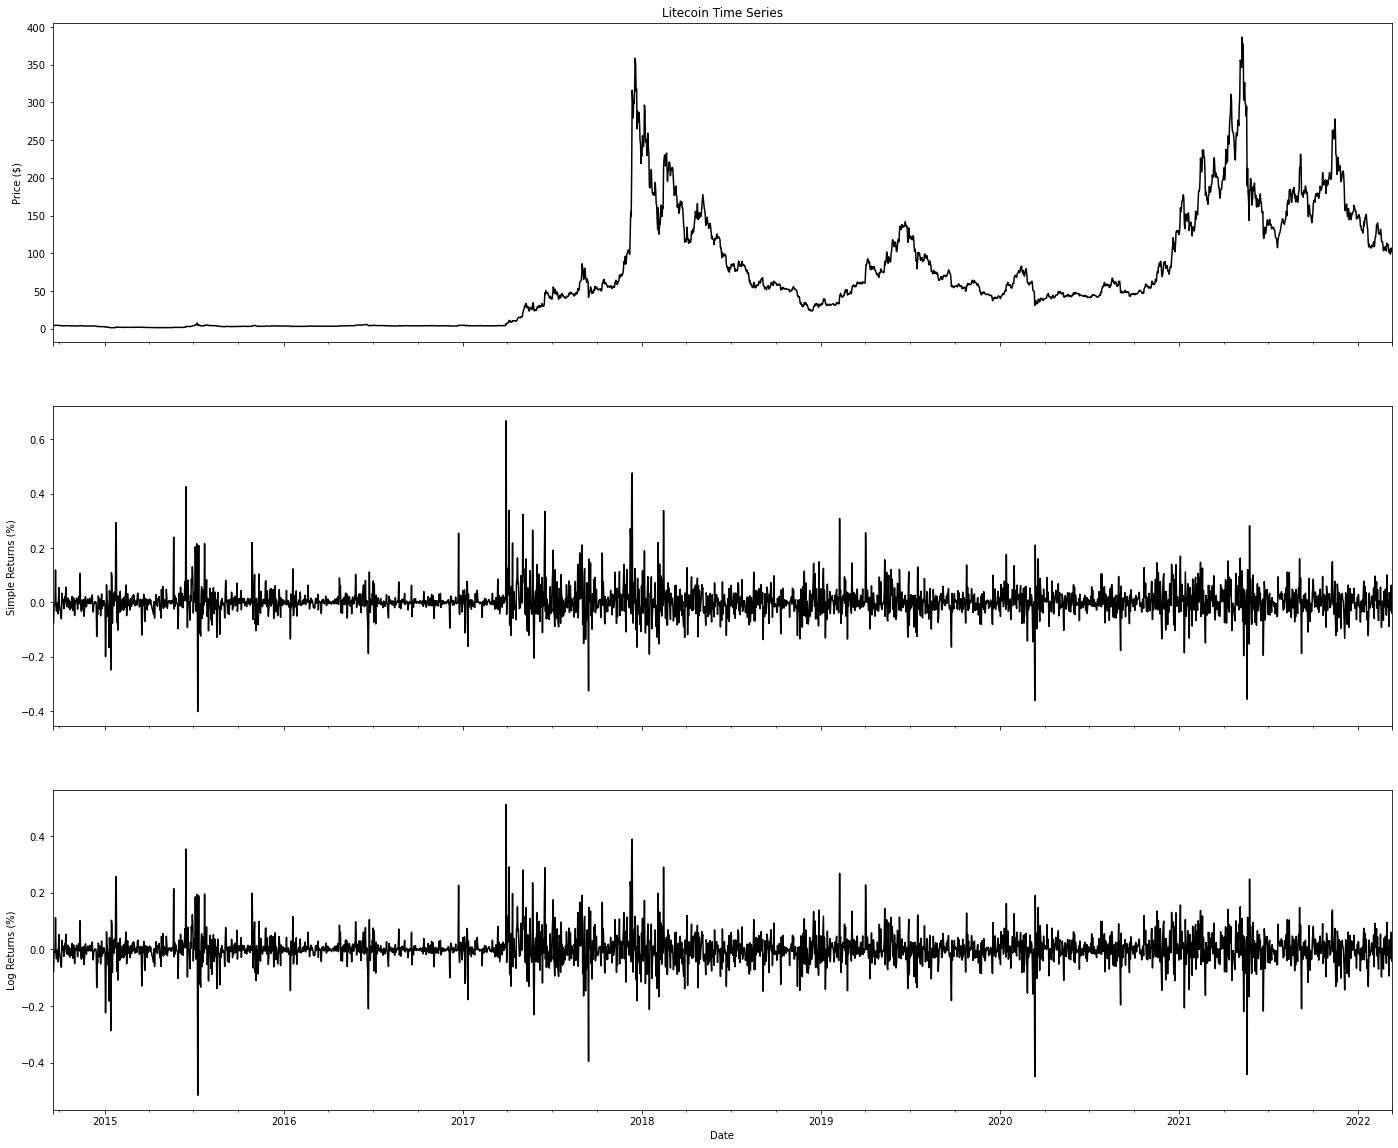

In [9]:
fig, ax = plt.subplots(3,1,figsize=(24,20), sharex=True)
ltc.adj_close.plot(ax=ax[0], color = 'black')
ax[0].set(title = 'Litecoin Time Series',
          ylabel = 'Price ($)')
ltc.simple_rtn.plot(ax=ax[1], color = 'black')
ax[1].set(ylabel = 'Simple Returns (%)')

ltc.log_rtn.plot(ax=ax[2], color = 'black')
ax[2].set(xlabel = 'Date', ylabel = 'Log Returns (%)')
plt.show()